# Creating a linear regression model for "House Sales in King County, USA" dataset

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from scipy.stats.mstats import normaltest

pd.options.display.float_format = '{:.2f}'.format

Read the data in and inspect the dimensions.

In [2]:
#Available from https://www.kaggle.com/harlfoxem/housesalesprediction
house_data = pd.read_csv("D:\Data_sets\kc_house_data.csv")
house_data.shape

(21613, 21)

Take a look at the descriptive statistics

In [3]:
house_data.describe()

id      price  bedrooms  bathrooms  sqft_living   sqft_lot  \
count      21613.00   21613.00  21613.00   21613.00     21613.00   21613.00   
mean  4580301520.86  540088.14      3.37       2.11      2079.90   15106.97   
std   2876565571.31  367127.20      0.93       0.77       918.44   41420.51   
min      1000102.00   75000.00      0.00       0.00       290.00     520.00   
25%   2123049194.00  321950.00      3.00       1.75      1427.00    5040.00   
50%   3904930410.00  450000.00      3.00       2.25      1910.00    7618.00   
75%   7308900445.00  645000.00      4.00       2.50      2550.00   10688.00   
max   9900000190.00 7700000.00     33.00       8.00     13540.00 1651359.00   

        floors  waterfront     view  condition    grade  sqft_above  \
count 21613.00    21613.00 21613.00   21613.00 21613.00    21613.00   
mean      1.49        0.01     0.23       3.41     7.66     1788.39   
std       0.54        0.09     0.77       0.65     1.18      828.09   
min       1.00        0.00     0.00       1.00     1.00      290.00   
25%       1.00        0.00     0.00       3.00     7.00     1190.00   
50%       1.50        0.00     0.00       3.00     7.00     1560.00   
75%       2.00        0.00     0.00       4.00     8.00     2210.00   
max       3.50        1.00     4.00       5.00    13.00     9410.00   

       sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
count       21613.00  21613.00      21613.00 21613.00 21613.00 21613.00   
mean          291.51   1971.01         84.40 98077.94    47.56  -122.21   
std           442.58     29.37        401.68    53.51     0.14     0.14   
min             0.00   1900.00          0.00 98001.00    47.16  -122.52   
25%             0.00   1951.00          0.00 98033.00    47.47  -122.33   
50%             0.00   1975.00          0.00 98065.00    47.57  -122.23   
75%           560.00   1997.00          0.00 98118.00    47.68  -122.12   
max          4820.00   2015.00       2015.00 98199.00    47.78  -121.31   

       sqft_living15  sqft_lot15  
count       21613.00    21613.00  
mean         1986.55    12768.46  
std           685.39    27304.18  
min           399.00      651.00  
25%          1490.00     5100.00  
50%          1840.00     7620.00  
75%          2360.00    10083.00  
max          6210.00   871200.00

In [4]:
num_attribs = list(house_data.columns.difference(['id','date','zipcode'])) # only check numeric variables
num_attribs = house_data.loc[:,num_attribs].copy()
num_attribs.shape 

(21613, 18)

Check for outliers

In [5]:
datacopy = num_attribs.copy()
for col in datacopy.columns:
    datacopy[col] = (datacopy[col] - datacopy[col].mean()) / datacopy[col].std()

datacopy = datacopy[datacopy > 10].dropna(axis=1, how = 'all').dropna(axis=0, how = 'all') # more than 10 standard deviations away

outliers = datacopy.iloc[:,:6].dropna(axis=0,how='all').copy()

outliers.shape[0]

67

In [6]:
house_data = house_data.loc[house_data.index.difference(outliers.index),:]

Check for collinearity between numeric variables (collinearity violates assumptions of linear regression). 

In [7]:
def plot_corr(df, size=8, coef_cutoff=0.5):

    corr = df.corr()
    corr = corr[(abs(corr) > coef_cutoff)&(corr != 1)].dropna(axis=1,how='all').dropna(how='all')
    
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    
    fig, ax = plt.subplots()
    fig.set_size_inches(size, size)
    fig.set_facecolor('white')
    
    with sns.axes_style("white"):
        sns.heatmap(corr, ax=ax, mask=mask, annot=True, square=True, cmap='Reds', vmin=coef_cutoff, vmax=1)
        plt.xticks(rotation=90, size=13)
        plt.yticks(size=13)

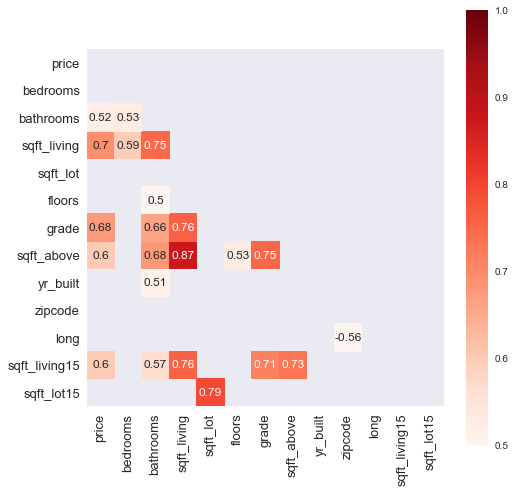

In [8]:
plot_corr(house_data)

Large collinearity can be seen between sqft_above and sqft_living, which makes intuitive sense, if your house has a large floor space, it is likely to have a large second floor space (unless you live in a pyramid). The highest correlation with price is sqft_living, which means it is likely to play a large role in predicting house prices. Scatter plots of the most correlated variables confirm what we found:

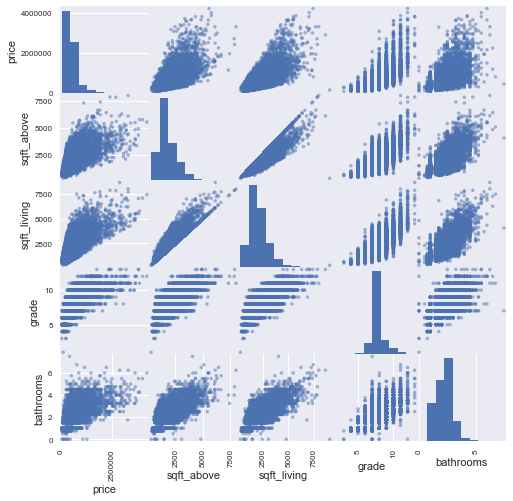

In [9]:
pd.plotting.scatter_matrix(house_data.loc[:,['price','sqft_above', 'sqft_living','grade','bathrooms']], figsize=(8, 8));

Linear regression assumes a linear relationship between the target (in our case price) and the independent variables. The shape of the scatter plots indicates this is likely.

Unfortunately, as we are using multivariate linear regression, multicollinearity may also exist in the variables. Checking for this is not as simple as looking at the correlation graph as that cannot highlight interaction effects. I have found two ways to check for multicollinearity:

1. Inspecting the eigen values of the correlation matrix. Explained well here: (https://stackoverflow.com/questions/25676145/capturing-high-multi-collinearity-in-statsmodels)  

2. Calculating the variance inflation factors (VIF). As described in Introduction to statistical learning, pg 101-102.

Both methods are compared below:

In [10]:
corr = np.corrcoef(num_attribs, rowvar=0)
w, v = np.linalg.eig(corr)

list(zip(list(w), num_attribs.columns))

[(5.588364153469259, 'bathrooms'),
 (2.2406826792780681, 'bedrooms'),
 (1.8050995692789571, 'condition'),
 (1.3199131852359243, 'floors'),
 (1.1221419709030422, 'grade'),
 (1.0027017257359783, 'lat'),
 (0.85964780643008476, 'long'),
 (0.77851671840789483, 'price'),
 (0.65987333879443466, 'sqft_above'),
 (0.59235500846538036, 'sqft_basement'),
 (0.510971337226794, 'sqft_living'),
 (0.18423727822473585, 'sqft_living15'),
 (0.19923174537615676, 'sqft_lot'),
 (0.24110504199024124, 'sqft_lot15'),
 (0.26502777266523703, 'view'),
 (0.29802790493102621, 'waterfront'),
 (0.33210276358679602, 'yr_built'),
 (2.1511208074157829e-16, 'yr_renovated')]

Eigen values close to 0 indicate collinearity.

$VIF(\hat{\beta}_j) = \frac{1}{1 − R^2_{X_j | X_−j}}$ where $R^2_{X_j | X_−j}$ is the $R^2$ from a regression of $X_j$ onto all of the other predictors. If it is close to 1, collinearity is present and the VIF will be large.  

In [13]:
def variance_inflation_factor(df):

    resultdict = {}
    
    for col in df.columns:
        
        mask = list(df.columns.difference([col]))
        
        X = df.loc[:,mask].values
        y = df[col].values

        reg_mod = LinearRegression()
        reg_mod.fit(X,y)
        reg_mod_pred = reg_mod.predict(X)
           
        r2score = r2_score(y, reg_mod_pred)
        
        if r2score == 1:
            vif = '~inf'
            resultdict[col] = vif
            continue
        
        vif = 1. / (1. - r2score)
        resultdict[col] = vif
    
    return pd.DataFrame(resultdict, index=['VIF']).T

In [14]:
eigs = pd.DataFrame(dict(zip(num_attribs.columns,list(w))), ['Eigen value']).T
results_table = eigs.join(variance_inflation_factor(num_attribs))

In [15]:
results_table.sort_values(by='Eigen value', ascending=False)

Eigen value   VIF
bathrooms             5.59  3.38
bedrooms              2.24  1.67
condition             1.81  1.24
floors                1.32  1.99
grade                 1.12  3.73
lat                   1.00  1.27
long                  0.86  1.51
price                 0.78  3.28
sqft_above            0.66  ~inf
sqft_basement         0.59  ~inf
sqft_living           0.51  ~inf
yr_built              0.33  2.52
waterfront            0.30  1.27
view                  0.27  1.46
sqft_lot15            0.24  2.14
sqft_lot              0.20  2.10
sqft_living15         0.18  2.96
yr_renovated         -0.00  1.15

Interestingly, the two methods have slightly different results. The Eigen values close to 0 and higher VIF scores indicate collinearity. The VIF results make more intuitive sense, the sqft variables are all highly correlated. The Eigen value for yr_renovated is close to 0, so it must be highly correlated with another variable? It must be yr_built?

In [15]:
house_data.corr().loc[:,'yr_renovated']

id              -0.02
price            0.12
bedrooms         0.02
bathrooms        0.05
sqft_living      0.05
sqft_lot         0.01
floors           0.01
waterfront       0.09
view             0.10
condition       -0.06
grade            0.01
sqft_above       0.02
sqft_basement    0.07
yr_built        -0.22
yr_renovated     1.00
zipcode          0.07
lat              0.03
long            -0.07
sqft_living15   -0.00
sqft_lot15       0.01
Name: yr_renovated, dtype: float64

It doesnt seem strongly correlated with any of the variables, even year built is a weak correlation. I would love to hear your thoughts on this? Seems the VIF scores are more useful in this scenario. The correlated variables were removed, leaving in sqft_living.

In [16]:
num_names = list(num_attribs.columns.difference(['price','sqft_above','sqft_basement']))

The variables now need preprocessing. Scikit-learn makes use of duck-typing, custom transformers are easy to write to put into pipelines.

In [17]:
class DataFrameSelector(BaseEstimator, TransformerMixin): #select only the numeric variables for processing
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [18]:
first_pipeline = Pipeline([
        ('selector',DataFrameSelector(num_names)), 
        ('imputer', Imputer(strategy="median")), # replace missing values with medians
        ('std_scaler', StandardScaler()), # standardise variables to prevent larger scales dominating
    ])

In [19]:
house_data_processed = first_pipeline.fit_transform(house_data)

Fitting the model

In [20]:
lin_reg = LinearRegression()
lin_reg.fit(house_data_processed, house_data['price'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [21]:
lin_reg_predictions = lin_reg.predict(house_data_processed)

Assessing the fit

In [22]:
mse = mean_squared_error(house_data['price'], lin_reg_predictions)
rmse = np.sqrt(mse)
rmse

190580.4564923931

In [23]:
pd.DataFrame(house_data['price'].describe())

price
count   21546.00
mean   537224.19
std    349067.34
min     75000.00
25%    321000.00
50%    450000.00
75%    642757.50
max   4208000.00

Seems like a fair fit, given the distribution of prices.

In [24]:
r2score = r2_score(house_data['price'], lin_reg_predictions)
r2score

0.70190242414791859

70.1% of the variance is explained by the independent variables.

Whilst it is difficult to plot all the dimensions, looking at the variable most correlated with price is interesting:

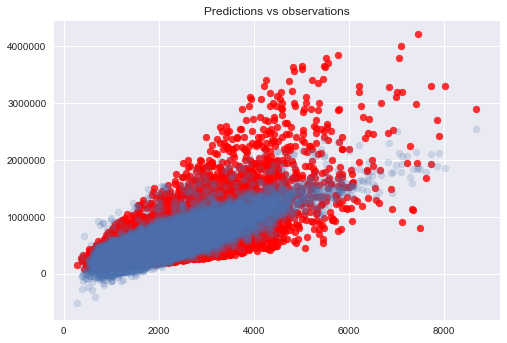

In [25]:
plt.scatter(house_data['sqft_living'], house_data['price'], color='red', alpha=0.8)
plt.scatter(house_data['sqft_living'], lin_reg_predictions, alpha=0.2)
plt.title('Predictions vs observations');

Linear regression assumes constant variance of the residuals. The standard errors, confidence intervals, and hypothesis tests associated with the linear model rely upon this assumption.

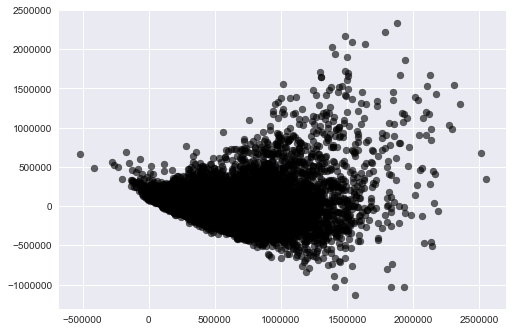

In [26]:
residuals = house_data['price'] - lin_reg_predictions
plt.scatter(lin_reg_predictions, residuals,  color='black', alpha=0.6);

The residuals have a clear trend, this is a bad sign. One option is to train the model using a transformed target variable, using a concave function such as $log(Y)$.

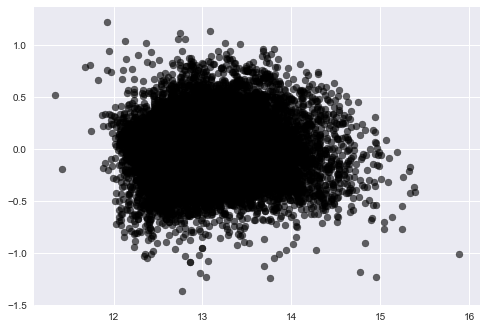

In [27]:
lin_reg2 = LinearRegression()
lin_reg2.fit(house_data_processed, np.log(house_data['price']))
lin_reg_predictions2 = lin_reg2.predict(house_data_processed)
residuals2 = np.log(house_data['price']) - lin_reg_predictions2
plt.scatter(lin_reg_predictions2, residuals2,  color='black', alpha=0.6);

This has improved the residual plots, and there is no discernable pattern. 

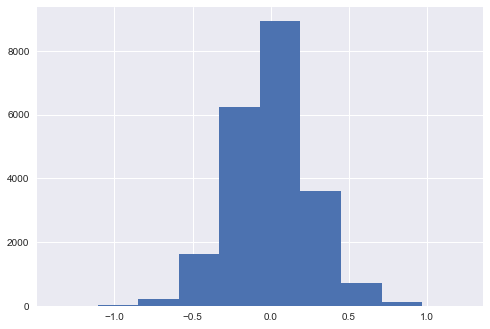

In [28]:
plt.hist(residuals2,bins=10);

In [29]:
normaltest(residuals2)

NormaltestResult(statistic=346.90977194590164, pvalue=4.6719712629468353e-76)

The residuals are normally distributed.

In [30]:
r2score2 = r2_score(np.log(house_data['price']), lin_reg_predictions2)
r2score2

0.76645423574830063

It has also improved the performance of the model

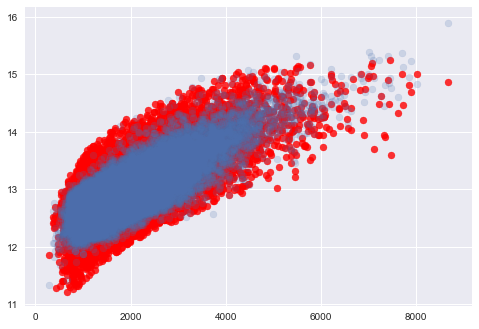

In [31]:
plt.scatter(house_data['sqft_living'], np.log(house_data['price']), color='red', alpha=0.8)
plt.scatter(house_data['sqft_living'], lin_reg_predictions2, alpha=0.2);

The model seems to follow the trend more closely now.

### Elastic Net

Elastic net is a combination of l1 and l2 regularisation, controlled by a ratio parameter, 'l1_ratio'. It is a mix of Lasso and Ridge regression.

The cost function $J(\theta) = MSE(\theta) + r\alpha \sum_{i=1}^n |\theta_i| + \frac{1-r}{2}\alpha \sum_{i=1}^n \theta_i^2$  
where r is the l1 ratio and $\theta$ is the coefficient vector.

In [32]:
elastic_net = ElasticNet(alpha=0.01, l1_ratio=0.5)
elastic_net.fit(house_data_processed, np.log(house_data['price']))
elastic_net_predictions = elastic_net.predict(house_data_processed)
r2score2 = r2_score(np.log(house_data['price']), elastic_net_predictions)
r2score2

0.76505393570084701

Slight performance decrease; however effect on variance and bias is unclear.

In [33]:
kf = KFold(n_splits=10)
X = house_data_processed
y = np.log(house_data['price'])

nonreg = np.mean(cross_val_score(lin_reg, X, y, cv=kf))
elastic = np.mean(cross_val_score(elastic_net, X, y, cv=kf))

print("Non regularised 10 fold CV score: {}".format(nonreg))
print("Elastic Net 10 fold CV score: {}".format(elastic))

Non regularised 10 fold CV score: 0.762449449137995
Elastic Net 10 fold CV score: 0.7610925746737677


Regularising the training does not seem to improve the performance; however, further searching for hyperparameters is necessary.

In summary: After removing outliers, the linear regression model captures ~76% of the variance in house prices. Checked 5 of the 6 assumptions of linear regression:

1. Non-linearity of the response-predictor relationships.
2. Correlation of error terms.
3. Non-constant variance of error terms.
4. Outliers.
5. High-leverage points.
6. Collinearity.

Future todo: 

- Use stepwise regression to test combinations of features
- Test for high-leverage points
- Add polynomial features and check bias-variance trade off using learning curves.  